<a href="https://colab.research.google.com/github/Vikas-KM/quora-question-pair/blob/main/solving_quora_question_pair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [1]:
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import math
import gc
import re

from bs4 import BeautifulSoup


import tqdm
# from tqdm import notebook
from difflib import SequenceMatcher
from wordcloud import WordCloud


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
! pip3 install fuzzywuzzy

In [5]:
from fuzzywuzzy import fuzz
import pickle


/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Dowloading the Data from the Kaggle
- https://www.kaggle.com/c/quora-question-pairs

In [1]:
! ls

sample_data


In [2]:
! pip install -q kaggle

In [3]:
! pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=2f717debde4ee34e545c5398ae19df0bbb36ed28e49719b7641a76f5d344a5cb
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [4]:
from google.colab import files

In [ ]:
files.upload()

In [6]:
! mkdir ~/.kaggle

In [7]:
cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets list

ref                                                           title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
utkarshxy/who-worldhealth-statistics-2020-complete            World Health Statistics 2020|Complete|Geo-Analysis    1MB  2021-01-10 18:25:49           2776        297  1.0              
gpreda/pfizer-vaccine-tweets                                  Pfizer Vaccine Tweets                               541KB  2021-01-13 08:04:33           1723        131  1.0              
arashnic/covid19-case-surveillance-public-use-dataset         Covid-19 Case Surveillance Public Use Dataset        46MB  2020-12-21 02:24:21           1415         66  1.0              
ashkhagan/women-representation-in-city-property-sanfrancisco  Women Re

In [10]:
! pip install --upgrade --force-reinstall --no-deps kaggle


Processing /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10/kaggle-1.5.10-cp36-none-any.whl
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [11]:
! kaggle competitions download -c quora-question-pairs


 99% 305M/309M [00:03<00:00, 81.3MB/s]
100% 309M/309M [00:03<00:00, 87.6MB/s]


In [12]:
! ls

kaggle.json  quora-question-pairs.zip  sample_data


In [13]:
! unzip quora-question-pairs.zip

Archive:  quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [14]:
! ls

kaggle.json		  sample_submission.csv.zip  train.csv.zip
quora-question-pairs.zip  test.csv
sample_data		  test.csv.zip


In [15]:
! unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [16]:
! ls

kaggle.json		  sample_submission.csv.zip  train.csv
quora-question-pairs.zip  test.csv		     train.csv.zip
sample_data		  test.csv.zip


In [49]:
# zf = zipfile.ZipFile('/kaggle/input/quora-question-pairs/train.csv.zip')
# df_train = pd.read_csv(zf.open('train.csv'))


df = pd.read_csv('train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Examples of duplicate examples

In [50]:
# change the index of iloc to see different questions to get and idea
df1 = df[df['is_duplicate'] == 0]
df2 = df[df['is_duplicate'] == 1]

qstn1 = df1.iloc[0]['question1']
qstn2 = df1.iloc[0]['question2']
is_dup1 = df1.iloc[0]['is_duplicate']

qstn3 = df2.iloc[0]['question1']
qstn4 = df2.iloc[0]['question2']
is_dup2 = df2.iloc[0]['is_duplicate']


print(qstn1)
print(qstn2)
print('are they duplicates? ', is_dup1)

print(qstn3)
print(qstn4)
print('are they duplicates? ', is_dup2)

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?
are they duplicates?  0
Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
are they duplicates?  1


## basic analysis on the train data

In [51]:
# how many data points
df.shape

(404290, 6)

In [52]:
# names of the columns
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [53]:
# how is data spread, finding the balance/imbalance of the data
df['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [54]:
# any null values present
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [56]:
print('{}% of duplicate pairs of question'.format(round(df['is_duplicate'].mean()*100,2)))

36.92% of duplicate pairs of question


## Exploratory Data Analysis

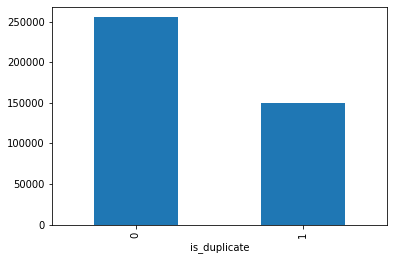

In [57]:
# count of duplicate and not duplicate questions
df.groupby('is_duplicate')['id'].count().plot.bar()


### references
- https://datatofish.com/convert-pandas-dataframe-to-list/
- https://queirozf.com/entries/pandas-dataframe-examples-duplicated-data

In [58]:
df['qid1'].value_counts()

8461      50
14110     48
25984     47
20628     47
1749      47
          ..
415339     1
411241     1
413288     1
409190     1
524288     1
Name: qid1, Length: 290654, dtype: int64

In [59]:
df['qid2'].value_counts()

30782     120
2559      115
4044      100
2561       71
17978      66
         ... 
99475       1
105616      1
85130       1
525311      1
288755      1
Name: qid2, Length: 299364, dtype: int64

### Observations
- Some qids are repeated, that means few questions are repeating

In [60]:
# number of unique questions
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
total_qstns = len(qids)
unique_qstns = len(np.unique(qids))
repeated_qstns = np.sum(qids.value_counts() >1)
print('Total number of questions ',total_qstns)
print('Total number of uniques questions ',unique_qstns)
print('Total number of repeated questions',repeated_qstns)


Total number of questions  808580
Total number of uniques questions  537933
Total number of repeated questions 111780


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


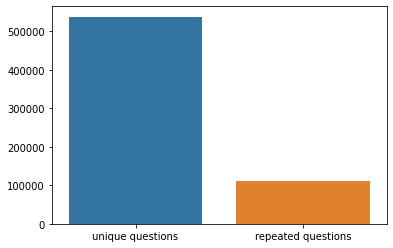

In [61]:
x=['unique questions', 'repeated questions']
y=[unique_qstns, repeated_qstns]
sns.barplot(x, y)

In [62]:
# how many times questions are repeated max?
qids.value_counts().iloc[:10]

2559     157
30782    120
4044     111
2561      88
14376     79
17978     77
2675      68
28764     66
1772      63
24555     61
dtype: int64

Text(0, 0.5, 'Number of questions')

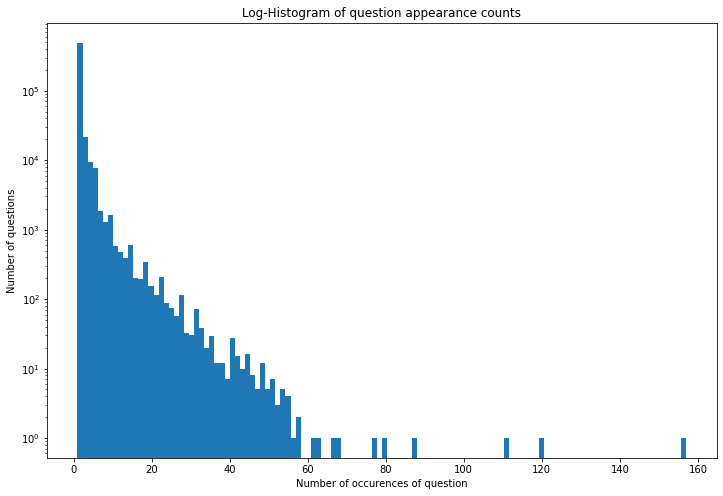

In [63]:
# questions are in huge numbers so taking logscale for y axis
# nonposy=clip mean negative of log not defined so here a small value is taken

plt.figure(figsize=(12, 8))
plt.hist(qids.value_counts(), bins=120)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

### Observations
- As from the above plot we can see, there is a question that is repeated 157, 120, 111 times
( see the above plot query for 157 number)

In [64]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [65]:
# finding rows that have NaN values
df[df.isna().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [66]:
gc.collect()

1932

### Observations
- There are 3 rows which have NaN value
    - we can delete those rows
    - we can fill them with a empty string
    
   
Since the NaN value are only 3 we will discard/drop them

### references
- https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

In [67]:
# droping the NaN values
df.dropna(axis=0, how='any', inplace=True)

In [68]:
df[df.isna().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [69]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [70]:
df.shape

(404287, 6)

In [71]:
## Checking if any pair is duplicate
dup = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
df.shape[0] - dup.shape[0]
del dup

### Naive Submission

In [ ]:
# from sklearn.metrics import log_loss

# p = df_train['is_duplicate'].mean() # Our predicted probability
# print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

# # zf = zipfile.ZipFile('/kaggle/input/quora-question-pairs/test.csv.zip')
# # df_test = pd.read_csv(zf.open('test.csv'))

# df_test = pd.read_csv('/kaggle/input/quora-question-pairs/test.csv')
# sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
# sub.to_csv('naive_submission.csv', index=False)
# sub.head()


Predicted score: 0.658528851473067


,test_id,is_duplicate
0,0,0.369201
1,1,0.369201
2,2,0.369201
3,3,0.369201
4,4,0.369201


In [ ]:
# df = pd.read_csv('./naive_submission.csv')
# df.shape

(2345796, 2)

## Feature Engineering

### Lets create a few new Features
- **freq_qid1, freq_qid2** -> Frequency count of the qids
- **qlen1, qlen2** -> Length of the question

- **q1_words, q2_words** -> Number of words in the question

### Cleaning for RAM Management later

In [72]:
# del df_test
# del df1
# del df2
gc.collect()

0

### References
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html
- https://pbpython.com/pandas_transform.html

In [73]:
# using pandas transform to count the frequency of the qstn based on qid
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1


In [74]:
# finding the length of the qstn and creating a new feature
df['qlen1'] = df['question1'].apply(lambda x:len(x))
df['qlen2'] = df['question2'].apply(lambda x:len(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39


In [75]:
# number of words in the questions
df['q1_words'] = df['question1'].apply(lambda x: len(x.split(' ')))
df['q2_words'] = df['question2'].apply(lambda x: len(x.split(' ')))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7


### References
- https://stackoverflow.com/questions/11938964/how-to-find-common-words-and-print-them-using-python-command/12136296

    - common = set(document_1_words).intersection( set(document_2_words) )
    - unique = set(document_1_words).symmetric_difference( set(document_2_words) )
    
    
- **common_words** -> common words to question1 and question2
- **total_words** -> total unique words to belonging to both question1 and question2
- **share_words** -> the share words is defined as common words divided by total words

In [76]:
# common words to both qstn1 and qstn2 
def word_common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return len(w1.intersection(w2))
df['common_words'] = df.apply(word_common, axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2


In [77]:
# Total words of both qstn1 and qstn2 
def word_total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return len(w1)+len(w2)
df['total_words'] = df.apply(word_total, axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20


In [78]:
# words shared between of both qstn1 and qstn2 
# gives us an idea as to how similar the two qstns maybe
# higher the share words implies more similar the wordings are of the two sentences

df['share_words'] = df['common_words']/(df['total_words'])
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000


- **freq_q1+freq_q2** = sum total of frequency of qid1 and qid2
- **freq_q1-freq_q2** = absolute difference of frequency of qid1 and qid2

In [79]:
df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

### Analysis from the extracted features

In [80]:
# minimum length of the question1
print('minimum length of the qstn1 is ',min(df['qlen1']))

# minimum length of the question2
print('minimum length of the qstn2 is ',min(df['qlen2']))

minimum length of the qstn1 is  1
minimum length of the qstn2 is  1


In [81]:
# questions of minimum length
print(df[df['qlen1']== 1].shape[0])
df[df['qlen1']== 1]['question1']

19


3306      .
13016     ?
20794     ?
96725     ?
104101    ?
108978    i
115347    o
134403    ?
151922    o
158778    A
189659    ?
190570    ‘
199110    I
208485    ?
213220    ?
254161    ?
273065    ?
357127    H
402423    ?
Name: question1, dtype: object

In [82]:
print(df[df['qlen2']== 1].shape[0])
df[df['qlen2']== 1]['question2']

2


47056     ?
198913    o
Name: question2, dtype: object

In [83]:
df.shape[0]

404287

### Observation
- There are 19 questions of Question1 which has only 1 character
- There are 2 questions of Question2 which has only 1 character

These 21 form a miniscule part(0.005%) of the training, we can drop them

In [84]:
min(df['q1_words'])

1

In [85]:
print(df[df['q1_words']== 1].shape[0])
df[df['q1_words']== 1]['question1']
print(df[df['q1_words']== 1]['question1'].value_counts())

66
?            11
deleted       9
Deleted.      5
What?         4
o             2
My            2
Why?          2
H             1
spam          1
Aaas          1
[removed]     1
I             1
sss           1
Na            1
Nana          1
…..           1
Error         1
Q?            1
Can?          1
A             1
i             1
Life:         1
hi            1
How           1
Is?           1
Marriage      1
‘             1
HH            1
.             1
111           1
Which         1
Cloning?      1
delete        1
grammar       1
Ok            1
civil         1
What          1
no            1
Name: question1, dtype: int64


In [86]:
min(df['q2_words'])

1

In [87]:
print(df[df['q2_words']== 1].shape[0])
df[df['q2_words']== 1]['question2']
print(df[df['q2_words']== 1]['question2'].value_counts())

22
What?            3
Spam             2
…………..           2
Deleted.         2
Hh               1
Why              1
[removed]        1
o                1
Delete           1
lol              1
Does?            1
deleted          1
?                1
Edit             1
????             1
parisflatlist    1
HH               1
Name: question2, dtype: int64


In [88]:
df[df['question2']=='Spam']

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
236655,236655,153211,347631,Why was spam is called spam?,Spam,0,1,2,28,4,6,1,1,7,0.142857,3,1
361480,361480,491330,347631,"As a 13 year old, how do I get out of my unliv...",Spam,0,1,2,57,4,14,1,0,15,0.000000,3,1


In [89]:
df[df['question2']=='deleted']

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
231313,231313,179756,341088,From where to download episode2 season 3 of Th...,deleted,0,1,1,54,7,10,1,0,11,0.0,2,0


### Observations
- There are 66 and 22 question with one word in question1 and Question2
- bunch of keywords are deleted/delete spam and lol and dots conveying nothing at all

In [90]:
df['share_words'][0:].head()

0    0.434783
1    0.200000
2    0.166667
3    0.000000
4    0.100000
Name: share_words, dtype: float64

##### Can the share_words be used to see if it will help to separate the given question pairs?

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


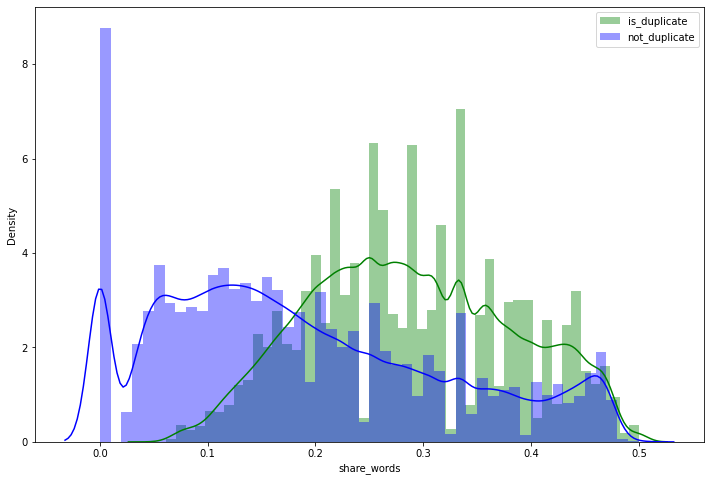

In [91]:
plt.figure(figsize=(12,8))
sns.distplot(df[df['is_duplicate'] == 1.0]['share_words'], label = "is_duplicate", color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['share_words'], label = "not_duplicate" , color = 'blue' )
plt.legend()
plt.show()

### Observation
- green indicates duplicates, higher share words means they may be duplicates
- blue indicates not duplicates, lower share words means they may not be duplicates

Since there is lot of overlap it is not strict separation as can be seen from the above graph

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


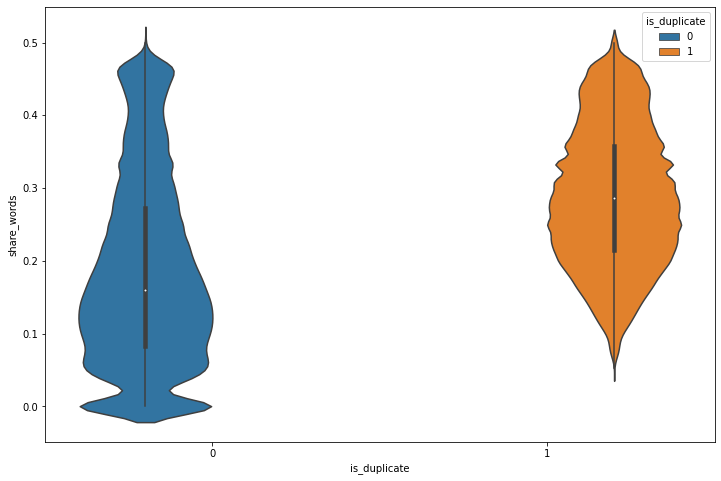

In [92]:
plt.figure(figsize=(12,8))
x = df['is_duplicate']
y = df['share_words']
sns.violinplot(x,y, hue=df['is_duplicate'])
plt.show()

##### Can the common_words be used to see if it will help to separate the given question pairs?

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


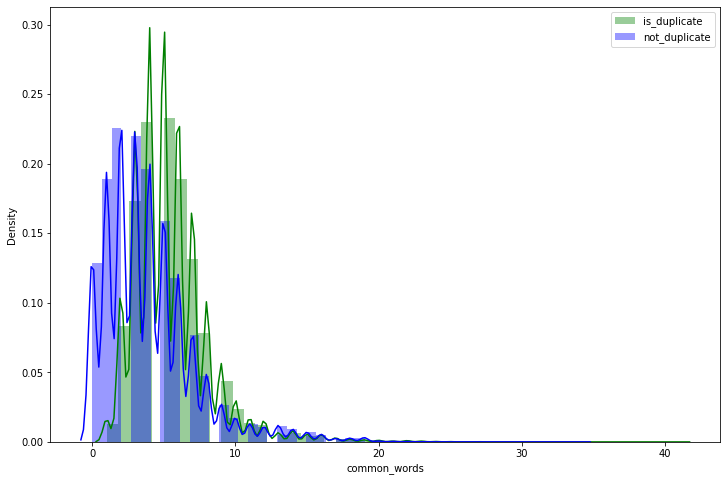

In [93]:
plt.figure(figsize=(12,8))
sns.distplot(df[df['is_duplicate'] == 1.0]['common_words'], label = "is_duplicate", color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['common_words'], label = "not_duplicate" , color = 'blue' )
plt.legend()
plt.show()

#### Observation:
- too much overlap

## Text Preprocessing

- Removing HTML Tags
- Removing Punctuations
- Removing Numbers
- Performing Stemming
- Removing Stop words etc

#### Code to remove URL links from text

In [94]:
# https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105
def remove_URL(text):
    """Remove URLs from a text string"""
    return re.sub(r"http\S+", "", text)

In [95]:
df['question1'] = df['question1'].apply(lambda x: x.lower())
df['question2'] = df['question2'].apply(lambda x: x.lower())

In [96]:
df['question1'] = df['question1'].apply(lambda x: remove_URL(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


In [97]:
df['question2'] = df['question2'].apply(lambda x: remove_URL(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


In [98]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
def getText(x):
    soup = BeautifulSoup(x, 'lxml')
    text = soup.get_text()
    return text

In [99]:
df['question1'] = df['question1'].apply(lambda x: getText(x))
df.head()

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


In [100]:
df['question2'] = df['question2'].apply(lambda x: getText(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


#### Expanding English language contractions in Python

In [101]:
! pip install contractions

     |████████████████████████████████| 317kB 4.2MB/s 
     |████████████████████████████████| 245kB 7.3MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81709 sha256=343c11da809dd8bc5267fc93871715196e58540bf2674ab3d499f8f835ec13af
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [102]:
import contractions

print(contractions.fix("i like this and 'll and you've"))
print(contractions.fix("he's"))
print(contractions.fix("'ll"))

i like this and  will and you have
he is
 will


In [ ]:
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490

# def decontracted(phrase):
#     # specific
#     phrase = re.sub(r"won\'t", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)

#     # general
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
#     phrase = re.sub(r"\'d", " would", phrase)
#     phrase = re.sub(r"\'ll", " will", phrase)
#     phrase = re.sub(r"\'t", " not", phrase)
#     phrase = re.sub(r"\'ve", " have", phrase)
#     phrase = re.sub(r"\'m", " am", phrase)
#     return phrase

In [103]:
# removing special characters
def remove_spl(x):
    x = re.sub('[^A-Za-z0-9]+', '', x)
    return x

In [104]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


### Text Preprocessing
- Remove stop words
- remove html tags
- remove punctuations
- Stemming
- Expanding contractions

In [105]:
def preprocess(x):
    x = str(x).lower()
    x = contractions.fix(x)
#     x = BeautifulSoup(x, 'lxml').get_text()
    x = re.sub('[^A-Za-z0-9]+', ' ', x) 
    return x.strip()

In [108]:
df['question1'] = df['question1'].apply(lambda x: preprocess(x))
df['question2'] = df['question2'].apply(lambda x: preprocess(x))

### Lets save this basic feature clean data for future


In [7]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [109]:
pickle.dump(df, open('/content/gdrive/My Drive/data-cleaned-basic-feature.csv', 'wb'))

## Advanced Feature Extraction
- **Token** - is when a sentence is split on space
- **stop_words** - stop words according to NLTK
- **word** - A token that is not stop word


- **cwc_min** : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
- cwc_min = common_word_count / (min(len(q1_words), len(q2_words))


- **cwc_max** : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
- cwc_max = common_word_count / (max(len(q1_words), len(q2_words))


- **csc_min** : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
- csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))


- **csc_max** : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
- csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))


- **ctc_min** : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
- ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))


- **ctc_max** : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
- ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))


- **last_word_eq** : Check if last word of both questions is equal or not
- last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])


- **first_word_eq** : Check if First word of both questions is equal or not
- first_word_eq = int(q1_tokens[0] == q2_tokens[0])


- **abs_len_diff** : Abs. length difference
- abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))


- **mean_len** : Average Token Length of both Questions
- mean_len = (len(q1_tokens) + len(q2_tokens))/2




- fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage 
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- **longest_substr_ratio** : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
- longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

- https://stackoverflow.com/questions/29050292/python3-x-list-assignment-index-out-of-range
- https://stackoverflow.com/questions/9272849/beginner-python-set-intersection-error

In [110]:
SAFE_DIV = 0.0001

def get_token_features(q1,q2):
    features = [0.0]*10
    q1_tokens = q1.split(' ')
    q2_tokens = q2.split(' ')
    q1_words = set([word for word in q1_tokens if word not in stop_words])
    q2_words = set([word for word in q2_tokens if word not in stop_words])
    q1_stops = set([word for word in q1_tokens if word in stop_words])
    q2_stops = set([word for word in q2_tokens if word in stop_words])
    
    common_word_count = len(q1_words.intersection(q2_words))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    features[0] = (common_word_count)/(min(len(q1_words), len(q2_words))+ SAFE_DIV)
    features[1] = (common_word_count)/(max(len(q1_words), len(q2_words))+ SAFE_DIV)
    
    features[2] = (common_stop_count)/(min(len(q1_stops), len(q2_stops))+ SAFE_DIV)
    features[3] = (common_stop_count)/(max(len(q1_stops), len(q2_stops))+ SAFE_DIV)
    
    features[4] = (common_token_count)/(min(len(q1_tokens), len(q2_tokens))+ SAFE_DIV)
    features[5] = (common_token_count)/(max(len(q1_tokens), len(q2_tokens))+ SAFE_DIV)
    
    features[6] = int(q1_tokens[0] == q2_tokens[0])
    features[7] = int(q1_tokens[-1] == q2_tokens[-1])
    features[8] = abs(len(q1_tokens) - len(q2_tokens))
    features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    return features
    
    

In [111]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'qlen1', 'qlen2', 'q1_words', 'q2_words',
       'common_words', 'total_words', 'share_words', 'freq_q1+q2',
       'freq_q1-q2'],
      dtype='object')

In [112]:
df['question1'].iloc[0]

'what is the step by step guide to invest in share market in india'

In [113]:
features = df.apply(lambda x: get_token_features(x['question1'],x['question2']), axis=1)

In [114]:
df["cwc_min"]       = list(map(lambda x: x[0], features))
df["cwc_max"]       = list(map(lambda x: x[1], features))
df["csc_min"]       = list(map(lambda x: x[2], features))
df["csc_max"]       = list(map(lambda x: x[3], features))
df["ctc_min"]       = list(map(lambda x: x[4], features))
df["ctc_max"]       = list(map(lambda x: x[5], features))
df["first_word_eq"]  = list(map(lambda x: x[6], features))
df["last_word_eq"] = list(map(lambda x: x[7], features))
df["abs_len_diff"]  = list(map(lambda x: x[8], features))
df["mean_len"]      = list(map(lambda x: x[9], features))

In [115]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,1,0,2,13.0
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,1,0,5,12.5
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,1,0,4,12.0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0,1,1,50,65,11,9,0,19,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2,12.0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,3,1,76,39,13,7,2,20,0.100000,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,1,0,6,10.0


- https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

In [116]:
df['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(x['question1'], x['question2']), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)
df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)

In [117]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,1,0,2,13.0,93,100,93,100
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,1,0,5,12.5,65,73,63,86
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,1,0,4,12.0,43,46,63,63


In [118]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'qlen1', 'qlen2', 'q1_words', 'q2_words',
       'common_words', 'total_words', 'share_words', 'freq_q1+q2',
       'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'first_word_eq', 'last_word_eq', 'abs_len_diff', 'mean_len',
       'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio',
       'token_set_ratio'],
      dtype='object')

- https://www.w3resource.com/python-exercises/string/python-data-type-string-exercise-69.php

In [119]:
  
def longest_substring_ratio(s1,s2): 
    
    seq_match = SequenceMatcher(None,s1,s2) 
    
    match = seq_match.find_longest_match(0, len(s1), 0, len(s2)) 
      
    if (match.size!=0):
        return match.size/(min(len(s1),len(s2)))
    else:
        return 0

# s1 = 'abcdefgh'
# s2 = 'xswerabcdwd'
# print("Original Substrings:\n",s1+"\n",s2)
# print("\nCommon longest sub_string:")
# print(longest_substring_ratio(s1,s2))

In [120]:
df['longest_substr_ratio'] = df.apply(lambda x: longest_substring_ratio(x['question1'], x['question2']), axis=1)

In [121]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,1,0,2,13.0,93,100,93,100,1.000000
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,1,0,5,12.5,65,73,63,86,0.583333
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,1,0,4,12.0,43,46,63,63,0.172414


In [122]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'qlen1', 'qlen2', 'q1_words', 'q2_words',
       'common_words', 'total_words', 'share_words', 'freq_q1+q2',
       'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'first_word_eq', 'last_word_eq', 'abs_len_diff', 'mean_len',
       'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio',
       'token_set_ratio', 'longest_substr_ratio'],
      dtype='object')

### Lets save the dataset with advanced features

In [125]:
pickle.dump(df, open('/content/gdrive/My Drive/data-cleaned-advanced-feature.csv', 'wb'))

In [126]:
import gc
del features
gc.collect()

308

In [8]:
df = pickle.load(open('/content/gdrive/My Drive/data-cleaned-advanced-feature.csv', 'rb'))

In [9]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,qlen1,qlen2,q1_words,q2_words,common_words,total_words,share_words,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,1,0,2,13.0,93,100,93,100,1.000000
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,1,0,5,12.5,65,73,63,86,0.583333
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,1,0,4,12.0,43,46,63,63,0.172414
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0,1,1,50,65,11,9,0,19,0.000000,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2,12.0,9,11,24,28,0.041667
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,3,1,76,39,13,7,2,20,0.100000,4,2,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,1,0,6,10.0,36,55,47,67,0.157895


## EDA on the new generated features
- Generate wordcloud on duplicate and non-duplicate questions

In [10]:
word_cloud_text = ''.join(df[df['is_duplicate']==0]['question1'])
word_cloud_text += ''.join(df[df['is_duplicate']==0]['question2'])
# df_dup = df[df['is_duplicate']==0]
# word_cloud_text = np.dstack([df_dup['question1'], df_dup['question2']]).flatten()

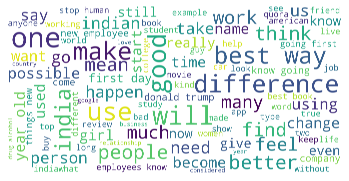

In [11]:
wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=1200, # Width of the canvas
                      height=600 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

In [12]:
gc.collect()

2229

In [13]:
word_cloud_text = ''.join(df[df['is_duplicate']==1]['question1'])
word_cloud_text += ''.join(df[df['is_duplicate']==1]['question2'])

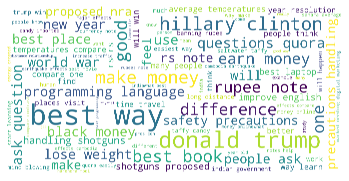

In [14]:
wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=1200, # Width of the canvas
                      height=600 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

In [15]:
del word_cloud_text
del wordcloud
gc.collect()

2229

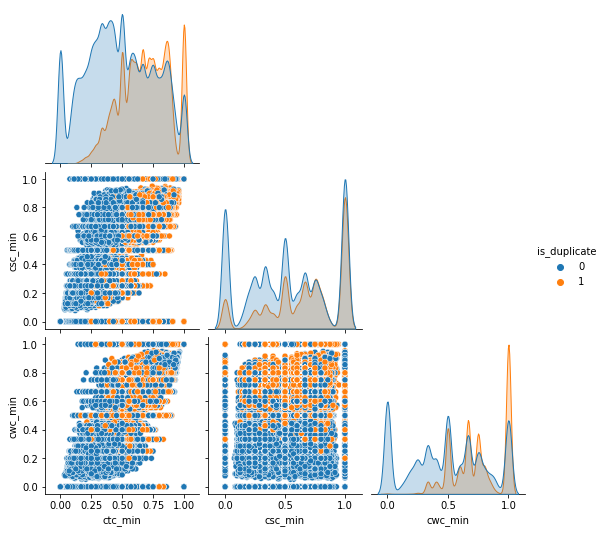

In [16]:
sns.pairplot(df, vars=["ctc_min", "csc_min", "cwc_min"], hue='is_duplicate', corner=True)

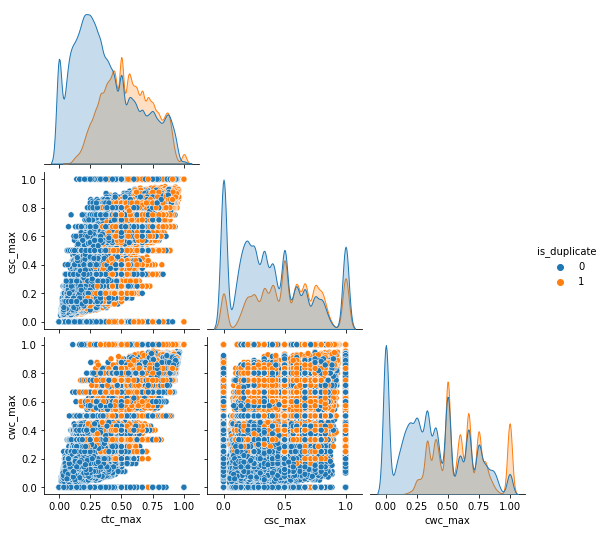

In [17]:
sns.pairplot(df, vars=["ctc_max", "csc_max", "cwc_max"], hue='is_duplicate', corner=True)

In [18]:
sns.pairplot(df, vars=["fuzz_ratio", "fuzz_partial_ratio", "token_sort_ratio", "token_set_ratio"], hue='is_duplicate', corner=True)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2b8dce4730> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f2b8da0bc80> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(df[df['is_duplicate'] == 0]['share_words'][0:] , label = "0", color = 'blue')
sns.distplot(df[df['is_duplicate'] == 1]['share_words'][0:] , label = "1", color = 'red')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='fuzz_ratio', data=df)
plt.subplot(1,2,2)
sns.boxplot(x='is_duplicate', y='fuzz_ratio', data=df)
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='fuzz_partial_ratio', data=df)
plt.subplot(1,2,2)
sns.boxplot(x='is_duplicate', y='fuzz_partial_ratio', data=df)
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='token_sort_ratio', data=df)
plt.subplot(1,2,2)
sns.boxplot(x='is_duplicate', y='token_sort_ratio', data=df)
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='token_set_ratio', data=df)
plt.subplot(1,2,2)
sns.boxplot(x='is_duplicate', y='token_set_ratio', data=df)
plt.show()

## Visualizing using t-SNE

In [ ]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'first_word_eq', 'last_word_eq' , 'abs_len_diff' , 'mean_len' , 'fuzz_ratio' , 'fuzz_partial_ratio' , 'token_sort_ratio', 'token_set_ratio' ,'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values
del dfp_subsampled

In [ ]:
from sklearn.manifold import TSNE

# most are default values itself

tsne2d = TSNE(
    n_components=2,
#     init='random', # pca
    random_state=42,
#     method='barnes_hut',
#     n_iter=1000,
    verbose=2,
#     angle=0.5
).fit_transform(X)

In [ ]:
df_temp = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_temp, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()
del df_temp
del tsne2d

In [ ]:
gc.collect()

In [ ]:
### we will use tfidf weighted word2vectors and pretrained model

In [ ]:
# import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

- https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

In [ ]:
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)


# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))


- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [ ]:
# df.to_pickle('df_processes.df')

In [ ]:
# df_preprocess = pd.read_pickle('/kaggle/output/df_preprocess.df')
# df_preprocess.head()

In [ ]:
len(word2tfidf)

In [ ]:
word2tfidf['step']

In [ ]:
# this is my corpus
questions[:10]

## word2vec application

#### Different Models with which you can play
- https://github.com/RaRe-Technologies/gensim-data
#### Explaining using word2vec wrt another problem
- https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751
#### official guide
- https://radimrehurek.com/gensim_3.8.3/sklearn_api/w2vmodel.html


In [ ]:
import gensim
import gensim.downloader as api

from nltk.tokenize import word_tokenize

info = api.info()
info

# model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)

In [ ]:
model = api.load("glove-wiki-gigaword-300")

In [ ]:
model.vector_size

In [ ]:
model.most_similar("cat")

In [ ]:
model['cat']

In [ ]:
# Collapse the list of strings into a single long string for processing
# questions_string = ' '.join(questions)

# from nltk.tokenize import word_tokenize

# # Tokenize the string into words
# tokens = word_tokenize(questions_string)

# words = [word for word in tokens if not word in stop_words]

# # Print first 10 words
# words[:10]

In [ ]:
# vector_list = [model[word] for word in tokens if word in model.vocab]
# len(vector_list), len(vector_list[0])

In [ ]:
# import spacy
# nlp = spacy.load('en_core_web_sm')
# nlp(questions[0])

In [ ]:
# nlp('step').vector

In [ ]:
# this is a float value
# word2tfidf[str('step')]

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
# nlp = spacy.load('en_core_web_sm')

import tqdm
from tqdm import notebook
import numpy as np

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in notebook.tqdm(list(df['question1'])):
#     doc1 = model(qu1) 
    tokens = word_tokenize(qu1)
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(tokens), 300])
    for word in tokens:
        # word2vec
#         vec1 = word1.vector
        if word in model.vocab:
            vec1 = model[word]
#         vec1 = np.array([model[word] word if word in model.vocab])
        # fetch df score
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

del vecs1


In [ ]:
import gc
del questions
# del questions_string
# del X

gc.collect()

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
# nlp = spacy.load('en_core_web_sm')

import tqdm
from tqdm import notebook

vecs2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu2 in notebook.tqdm(list(df['question2'])):
#     doc1 = model(qu1) 
    tokens = word_tokenize(qu2)
    mean_vec2 = np.zeros([len(tokens), 300])
    # 384 is the number of dimensions of vectors 
#     mean_vec1 = np.zeros([len(tokens), len(tokens[0])])
    for word in tokens:
        
        # word2vec
#         vec1 = word1.vector
#     vec2 = [model[word] for word in tokens if word in model.vocab]
        if word in model.vocab:
            vec2 = model[word]
        # fetch df score
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

del vecs2

In [ ]:
len(df['q1_feats_m'][0])

In [ ]:
df['question1'][0]

In [ ]:
df.index

In [ ]:
df_q1 = pd.DataFrame(df.q1_feats_m.values.tolist(), index= df.index)
df_q1.head()


In [ ]:
df_q2 = pd.DataFrame(df.q2_feats_m.values.tolist(), index= df.index)
df_q2.head()

In [ ]:
df_q1.rename(columns=str).columns + '_q1'

In [ ]:
df_q2.rename(columns=str).columns + '_q2'

In [ ]:
df_q1['id'] = df['id']
df_q2['id'] = df['id']

In [ ]:
df_temp = df_q1.merge(df_q2, how='left', on=df.index)
df_temp.head()

### save df_temp

In [ ]:
pickle.dump(df, open('/content/gdrive/My Drive/data-almost_final.csv', 'wb'))

In [ ]:
del df_q1
del df_q2
gc.collect()

In [ ]:
df_temp['id'] = df['id']
df_temp.head()

In [ ]:
df = df.merge(df_temp, how='left', on='id')
df.head()

In [ ]:
del df_temp
gc.collect()

In [ ]:
# we need to drop some columns which are not necessary
y_true = df['is_duplicate']
df.drop(['qid1','qid2','question1','question2','id_x','id_y'], axis=1, inplace=True)

In [ ]:
df.drop(['is_duplicate','id'], axis=1, inplace=True)
df.head()

In [ ]:
df.drop(['key_0'], axis=1, inplace=True)
df.head()

In [ ]:
cols = list(df.columns)
for i in cols:
    df[i] = df[i].apply(pd.to_numeric)
#     print(type(df[i]))

In [ ]:
df.head()

In [ ]:
# del cols
# del model

# del tfidf
# del word2tfidf

gc.collect()

In [ ]:
y_true = list(map(int, y_true.values))

In [ ]:
df.to_pickle('final.csv')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

## References
- https://medium.com/analytics-vidhya/quora-question-pairs-similarity-problem-8e3ae90441f0
- https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751
- https://nbviewer.jupyter.org/github/chambliss/Notebooks/blob/master/Word2Vec_News_Analysis.ipynb
- https://github.com/RaRe-Technologies/gensim-data
- https://www.guru99.com/tokenize-words-sentences-nltk.html
- https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1
- 

### References:
- https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/notebook
- https://www.kaggle.com/philschmidt/quora-eda-model-selection-roc-pr-plots
- https://www.kaggle.com/sudalairajkumar/simple-leaky-exploration-notebook-quora
- https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
- https://www.kaggle.com/liananapalkova/simply-about-word2vec
- https://www.kaggle.com/utsavdm/quora-question-pairs
- https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm